### Name-Babita Chaini
### Student Id - 21139211@student.ncirl.ie

## Beginning of Project

In [111]:
import requests
import json
import pandas as pd
import os
import seaborn as sns
import matplotlib as plt
import psycopg2
import plotly.graph_objects as go
import plotly.figure_factory as ff
import datetime
import pymongo as pym
import pandas as pd
from pymongo import MongoClient
import plotly.express as px

In [112]:
#Importing data using API
r = requests.get("https://www.fema.gov/api/open/v1/FemaWebDisasterDeclarations")

json_data = json.loads(r.content.decode("utf-8"))
json_data


{'metadata': {'skip': 0,
  'top': 1000,
  'count': 0,
  'filter': '',
  'format': 'json',
  'metadata': True,
  'select': None,
  'entityname': 'FemaWebDisasterDeclarations',
  'version': 'v1',
  'url': '/api/open/v1/FemaWebDisasterDeclarations',
  'rundate': '2022-04-21T15:39:09.237Z'},
 'FemaWebDisasterDeclarations': [{'disasterNumber': 3397,
   'declarationDate': '2018-02-11T00:00:00.000Z',
   'disasterName': 'TROPICAL STORM GITA',
   'incidentBeginDate': '2018-02-07T00:00:00.000Z',
   'incidentEndDate': '2018-02-12T00:00:00.000Z',
   'declarationType': 'Emergency',
   'stateCode': 'AS',
   'stateName': 'American Samoa',
   'incidentType': 'Hurricane',
   'entryDate': '2018-02-11T00:00:00.000Z',
   'updateDate': '2018-09-26T00:00:00.000Z',
   'closeoutDate': None,
   'hash': '0d548a11763653005b93ff0697cacdc6bc9c9cce',
   'lastRefresh': '2021-07-13T23:01:15.083Z',
   'id': '5aa2d570cb4f0f7020b1703a'},
  {'disasterNumber': 3390,
   'declarationDate': '2017-09-18T00:00:00.000Z',
   'di

### MongoDB connection

In [113]:

#connect on the default host and port.
client = MongoClient(host="localhost", port=27017)

In [114]:
client.test

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'test')

In [115]:
#Return a list of your system's databases:
dblist = client.list_database_names()

print(dblist)

['US_Disaster', 'admin', 'config', 'local']


In [116]:
db = "US_Disaster"

#Check if "mydatabase" exists:
if db in dblist:
  print(f"The database {db} exists.")

  #droping the database  
  client.drop_database(db) 

The database US_Disaster exists.


In [117]:
# Function to insert data into Mongo DB
def mongoimport(json_data, db_name, coll_name,db_url='localhost', db_port=27017):
    data_dict={}
    db = client[db_name]
    coll = db[coll_name]
    data_dict["data"] = json_data
    coll.insert_one(data_dict)

In [118]:
#Defining DB name and Collection name
database_name='US_Disaster'
collection_name='US_Disaster_Events'

In [119]:
# Create a database called "mydatabase":
mydb = client[database_name]

In [120]:
# Create a collection called "US_Disaster_Events":
mycol = mydb["US_Disaster_Events"]

In [121]:
#Loading data to MongoDB
mongoimport(json_data, database_name, collection_name)

In [122]:
#retrieving data from momgodb
df1=list(mydb.US_Disaster_Events.aggregate([{"$project":{"_id":0,"data.metadata":0}}]))

In [123]:
df1

[{'data': {'FemaWebDisasterDeclarations': [{'disasterNumber': 3397,
     'declarationDate': '2018-02-11T00:00:00.000Z',
     'disasterName': 'TROPICAL STORM GITA',
     'incidentBeginDate': '2018-02-07T00:00:00.000Z',
     'incidentEndDate': '2018-02-12T00:00:00.000Z',
     'declarationType': 'Emergency',
     'stateCode': 'AS',
     'stateName': 'American Samoa',
     'incidentType': 'Hurricane',
     'entryDate': '2018-02-11T00:00:00.000Z',
     'updateDate': '2018-09-26T00:00:00.000Z',
     'closeoutDate': None,
     'hash': '0d548a11763653005b93ff0697cacdc6bc9c9cce',
     'lastRefresh': '2021-07-13T23:01:15.083Z',
     'id': '5aa2d570cb4f0f7020b1703a'},
    {'disasterNumber': 3390,
     'declarationDate': '2017-09-18T00:00:00.000Z',
     'disasterName': 'HURRICANE MARIA',
     'incidentBeginDate': '2017-09-16T00:00:00.000Z',
     'incidentEndDate': '2017-09-22T00:00:00.000Z',
     'declarationType': 'Emergency',
     'stateCode': 'VI',
     'stateName': 'Virgin Islands of the U.S.'

### Transformations and Pre prossessing

In [124]:
# Normalizing the data obtained from Mongo DB
df2 = pd.json_normalize(df1, max_level=0)


In [125]:
bn = pd.DataFrame(df2.data.values.tolist())["FemaWebDisasterDeclarations"]

In [126]:
df3 = pd.DataFrame.from_records(bn).head

In [127]:
# Converting data obtained from MOngo DB to data frame df
disaster_data=[]
for i in bn.items():
    disaster_data.append([i[0],i[1]])
hh = pd.DataFrame(disaster_data,columns=["data","k"])
hh = hh.explode('k')
df = pd.json_normalize(json.loads(hh.to_json(orient = "records")))


In [128]:
df.head(10)

,data,k.disasterNumber,k.declarationDate,k.disasterName,k.incidentBeginDate,k.incidentEndDate,k.declarationType,k.stateCode,k.stateName,k.incidentType,k.entryDate,k.updateDate,k.closeoutDate,k.hash,k.lastRefresh,k.id
0,0,3397,2018-02-11T00:00:00.000Z,TROPICAL STORM GITA,2018-02-07T00:00:00.000Z,2018-02-12T00:00:00.000Z,Emergency,AS,American Samoa,Hurricane,2018-02-11T00:00:00.000Z,2018-09-26T00:00:00.000Z,None,0d548a11763653005b93ff0697cacdc6bc9c9cce,2021-07-13T23:01:15.083Z,5aa2d570cb4f0f7020b1703a
1,0,3390,2017-09-18T00:00:00.000Z,HURRICANE MARIA,2017-09-16T00:00:00.000Z,2017-09-22T00:00:00.000Z,Emergency,VI,Virgin Islands of the U.S.,Hurricane,2017-09-18T00:00:00.000Z,2018-09-07T00:00:00.000Z,2018-09-07T00:00:00.000Z,2f759fed8f206694f47538ffda1be535c6aa234f,2021-07-13T23:01:15.162Z,5aa2d570cb4f0f7020b1703f
2,0,4352,2017-12-20T00:00:00.000Z,SEVERE STORMS AND FLOODING,2017-10-04T00:00:00.000Z,2017-10-06T00:00:00.000Z,Major Disaster,NM,New Mexico,Flood,2017-12-21T00:00:00.000Z,2017-12-21T00:00:00.000Z,None,9426023f5a3c2be37671a5bb498848756552c2a4,2021-07-13T23:01:15.087Z,5aa2d570cb4f0f7020b1703b
3,0,3388,2017-09-08T00:00:00.000Z,HURRICANE IRMA,2017-09-04T00:00:00.000Z,2017-10-04T00:00:00.000Z,Emergency,FL,Florida,Hurricane,2017-09-09T00:00:00.000Z,2018-04-03T00:00:00.000Z,2018-03-28T00:00:00.000Z,0302a9f6b2dcbec3c243c6f03807b733d263983f,2021-07-13T23:01:15.173Z,5aa2d570cb4f0f7020b17040
4,0,3395,2017-10-08T00:00:00.000Z,HURRICANE NATE,2017-10-07T00:00:00.000Z,2017-10-11T00:00:00.000Z,Emergency,FL,Florida,Hurricane,2017-10-08T00:00:00.000Z,2017-10-13T00:00:00.000Z,None,8e70993c0499f478a5db4b69e761d53db128ea87,2021-07-13T23:01:15.114Z,5aa2d570cb4f0f7020b1703d
5,0,3392,2017-10-06T00:00:00.000Z,TROPICAL STORM NATE,2017-10-05T00:00:00.000Z,2017-10-08T00:00:00.000Z,Emergency,LA,Louisiana,Hurricane,2017-10-06T00:00:00.000Z,2017-10-13T00:00:00.000Z,None,df6da42bd45d0819eb850e937f551d08826f0e75,2021-07-13T23:01:15.154Z,5aa2d570cb4f0f7020b1703e
6,0,4332,2017-08-25T00:00:00.000Z,HURRICANE HARVEY,2017-08-23T00:00:00.000Z,2017-09-15T00:00:00.000Z,Major Disaster,TX,Texas,Hurricane,2017-08-26T00:00:00.000Z,2017-09-15T00:00:00.000Z,None,b5216b615cad6f6ba24751905d0b9d9c6b33fc68,2021-07-13T23:01:15.187Z,5aa2d570cb4f0f7020b17042
7,0,4348,2017-11-14T00:00:00.000Z,FLOODING,2017-05-02T00:00:00.000Z,2017-08-06T00:00:00.000Z,Major Disaster,NY,New York,Flood,2017-11-14T00:00:00.000Z,2017-11-14T00:00:00.000Z,None,d89a6c4e2b158cb462f414edb73991285f8b47fd,2021-07-13T23:01:15.097Z,5aa2d570cb4f0f7020b1703c
8,0,3384,2017-09-05T00:00:00.000Z,HURRICANE IRMA,2017-09-05T00:00:00.000Z,2017-09-07T00:00:00.000Z,Emergency,PR,Puerto Rico,Hurricane,2017-09-06T00:00:00.000Z,2017-09-18T00:00:00.000Z,None,7381db2d356a86658ab0562d051849619d413f8a,2021-07-13T23:01:15.177Z,5aa2d570cb4f0f7020b17041
9,0,4327,2017-08-05T00:00:00.000Z,FLOODING,2017-06-07T00:00:00.000Z,2017-06-22T00:00:00.000Z,Major Disaster,WY,Wyoming,Flood,2017-08-06T00:00:00.000Z,2017-08-06T00:00:00.000Z,None,e96f3b1cd09ff58f7c341c878adcbcce10f2e57e,2021-07-13T23:01:15.196Z,5aa2d570cb4f0f7020b17043


In [129]:
### Following Code is used to format date and time from the dataframe and rename the columns to a meaningful name

In [130]:
df['k.declarationDate'] = pd.to_datetime(df['k.declarationDate'])
df['declarationDate']=df['k.declarationDate'].dt.year
del df['k.declarationDate']

In [131]:
df['k.incidentBeginDate'] = pd.to_datetime(df['k.incidentBeginDate'])
df['incidentBeginDate']=df['k.incidentBeginDate'].dt.year
del df['k.incidentBeginDate']

In [132]:
df['k.incidentEndDate'] = pd.to_datetime(df['k.incidentEndDate'])
df['incidentEndDate']=df['k.incidentEndDate'].dt.year
del df['k.incidentEndDate']


In [133]:

df['k.entryDate'] = pd.to_datetime(df['k.entryDate'])
df['entryDate']=df['k.entryDate'].dt.year
del df['k.entryDate']

In [134]:
df['k.updateDate'] = pd.to_datetime(df['k.updateDate'])
df['updateDate']=df['k.updateDate'].dt.year
del df['k.updateDate']

In [135]:
df['k.closeoutDate'] = pd.to_datetime(df['k.closeoutDate'])
df['closeoutDate']=df['k.closeoutDate'].dt.year
del df['k.closeoutDate']

In [136]:
df['k.lastRefresh'] = pd.to_datetime(df['k.lastRefresh'])
df['lastRefresh']=df['k.lastRefresh'].dt.year
del df['k.lastRefresh']

In [137]:
df['disasterNumber']=df['k.disasterNumber']
del df['k.disasterNumber']

df['disasterName']=df['k.disasterName']
del df['k.disasterName']

df['declarationType']=df['k.declarationType']
del df['k.declarationType']

df['stateCode']=df['k.stateCode']
del df['k.stateCode']

df['stateName']=df['k.stateName']
del df['k.stateName']

df['incidentType']=df['k.incidentType']
del df['k.incidentType']

df['hash']=df['k.hash']
del df['k.hash']

df['id']=df['k.id']
del df['k.id']



In [138]:
# Deleting the not useful columns from data frame
del df['closeoutDate']
del df['incidentEndDate']

In [139]:
df.head(5)

,data,declarationDate,incidentBeginDate,entryDate,updateDate,lastRefresh,disasterNumber,disasterName,declarationType,stateCode,stateName,incidentType,hash,id
0,0,2018,2018,2018,2018,2021,3397,TROPICAL STORM GITA,Emergency,AS,American Samoa,Hurricane,0d548a11763653005b93ff0697cacdc6bc9c9cce,5aa2d570cb4f0f7020b1703a
1,0,2017,2017,2017,2018,2021,3390,HURRICANE MARIA,Emergency,VI,Virgin Islands of the U.S.,Hurricane,2f759fed8f206694f47538ffda1be535c6aa234f,5aa2d570cb4f0f7020b1703f
2,0,2017,2017,2017,2017,2021,4352,SEVERE STORMS AND FLOODING,Major Disaster,NM,New Mexico,Flood,9426023f5a3c2be37671a5bb498848756552c2a4,5aa2d570cb4f0f7020b1703b
3,0,2017,2017,2017,2018,2021,3388,HURRICANE IRMA,Emergency,FL,Florida,Hurricane,0302a9f6b2dcbec3c243c6f03807b733d263983f,5aa2d570cb4f0f7020b17040
4,0,2017,2017,2017,2017,2021,3395,HURRICANE NATE,Emergency,FL,Florida,Hurricane,8e70993c0499f478a5db4b69e761d53db128ea87,5aa2d570cb4f0f7020b1703d


In [140]:
# Check if any null values are present in data frame
check_nan_in_df = df.isnull().values.any()
print (check_nan_in_df)

False


### Visualization and Analysis

In [141]:

fig = px.scatter(df, x="incidentType", y="stateName")
fig.show()

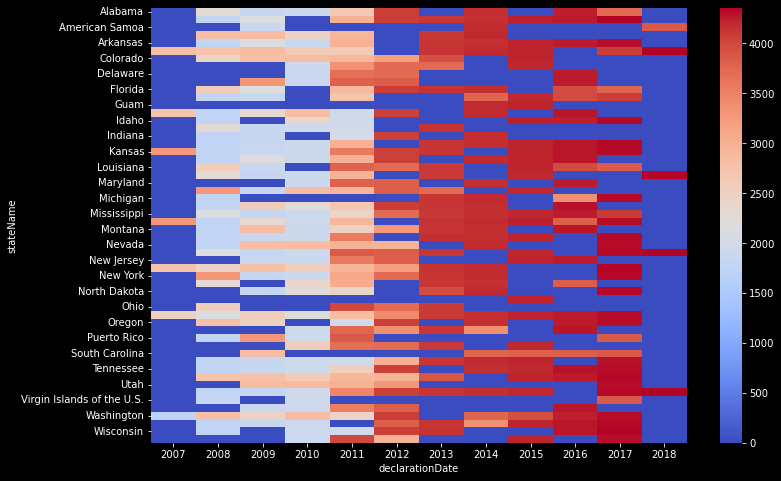

In [142]:
pt = df.pivot_table(values ='disasterNumber', index = 'stateName', columns = 'declarationDate').fillna(0)
plt.pyplot.figure(figsize=(12,8))
sns.heatmap(pt, cmap='coolwarm');
plt.pyplot.savefig('heatmap.png')

In [143]:


fig = px.histogram(df, x="declarationDate", y="disasterNumber", color="declarationDate", marginal="rug",
                   hover_data=df.columns)
fig.show()

In [144]:




fig = go.Figure(data=go.Scatter(x=df['stateCode'],
                                y=df['disasterNumber'],
                                mode='markers',
                                marker_color=df['disasterNumber'],
                                text=df['stateName'])) # hover text goes here

fig.update_layout(title='Number of Disasters happened in USA States from 2008 to 2018')
fig.show()

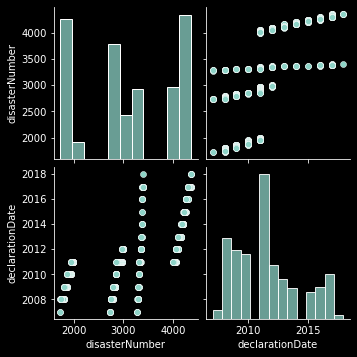

In [146]:

sns.pairplot(df[['disasterNumber','declarationDate']]);

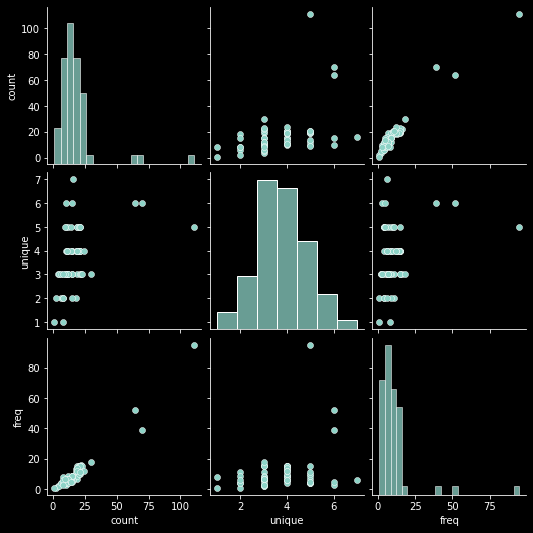

In [147]:
#Plotting count, unique and frequency from describe() function
m=df[['stateName','incidentType']].groupby('stateName').describe()
sns.pairplot(m['incidentType'].reset_index(drop=True));

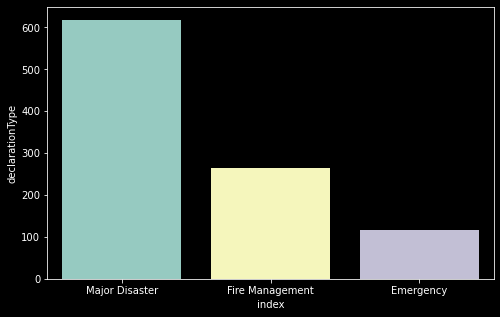

In [149]:
# To show which declaration Types is most Prominent in US Staes
plt.pyplot.figure(figsize=(8,5))
sns.barplot(x='index',y='declarationType',data=df['declarationType'].value_counts().reset_index());

<AxesSubplot:title={'center':'Number of Disasters Declared '}>

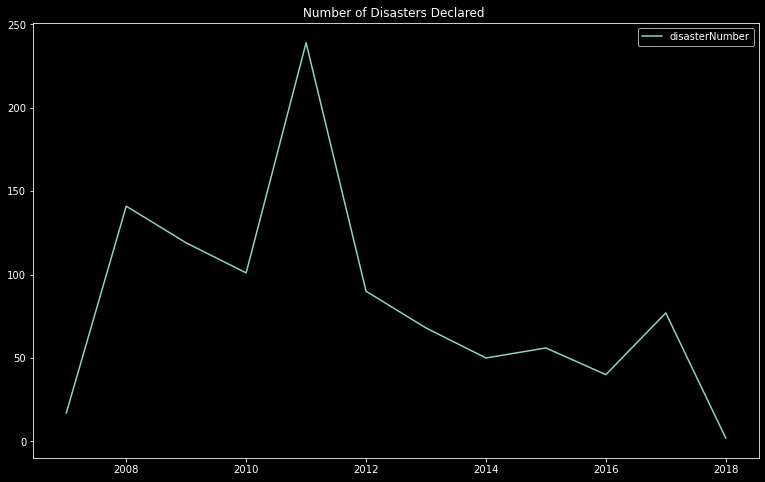

In [150]:
#Number of disasters declared per year
yearly_dcount = df.groupby(['incidentBeginDate']).size()

yearly_dcount=pd.DataFrame(yearly_dcount)
yearly_dcount.columns=['disasterNumber']


#Visualizing change in total number of disasters over time 
plt.style.use('dark_background')

yearly_dcount.reset_index().plot('incidentBeginDate','disasterNumber', title='Number of Disasters Declared ', xlabel='', figsize=(13, 8))


In [151]:
# Top ten state with maximum risk
p = df[['stateName','incidentType']].groupby('stateName').count()
p.reset_index(inplace=True)
p=p.sort_values(by='incidentType',ascending=False).head(10)
p

,stateName,incidentType
47,Texas,111
39,Oklahoma,70
5,California,64
33,New Mexico,30
52,Washington,24
27,Missouri,23
17,Iowa,22
18,Kansas,21
26,Mississippi,21
45,South Dakota,21


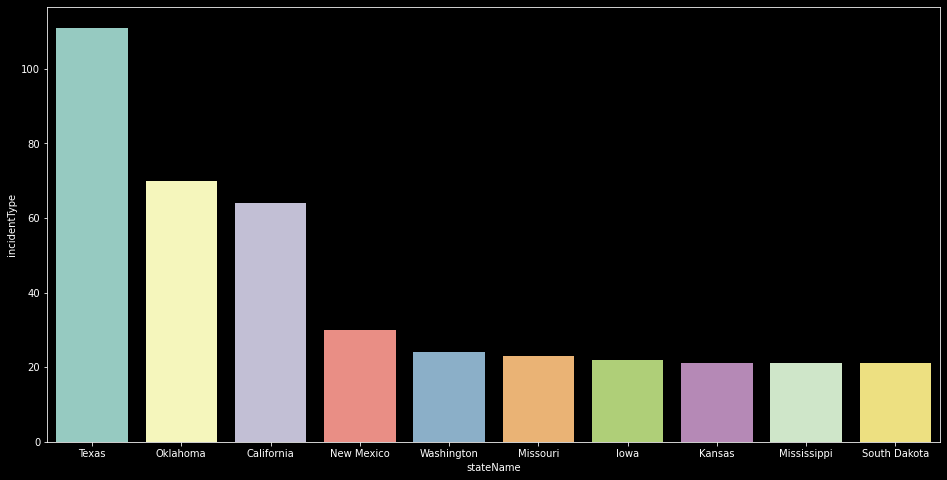

In [152]:
# To show top ten state in US which is worst hit by disaster
plt.pyplot.figure(figsize=(16,8))
sns.barplot(x="stateName", y="incidentType", data=p,);

In [153]:
# Interative Plot to show incidents happened in US Staes over time

fig = px.histogram(df, x="stateName", y="disasterNumber", color="incidentType", marginal="rug",
                   hover_data=df.columns)
fig.update_layout(title='Disaster Per State')
fig.show()

In [154]:
# To show trend of disaster over time
fig = px.line(df, x='declarationDate', y="disasterNumber")
fig.update_layout(title='Trend of disaster in USA States from 2008 to 2018')
fig.show()

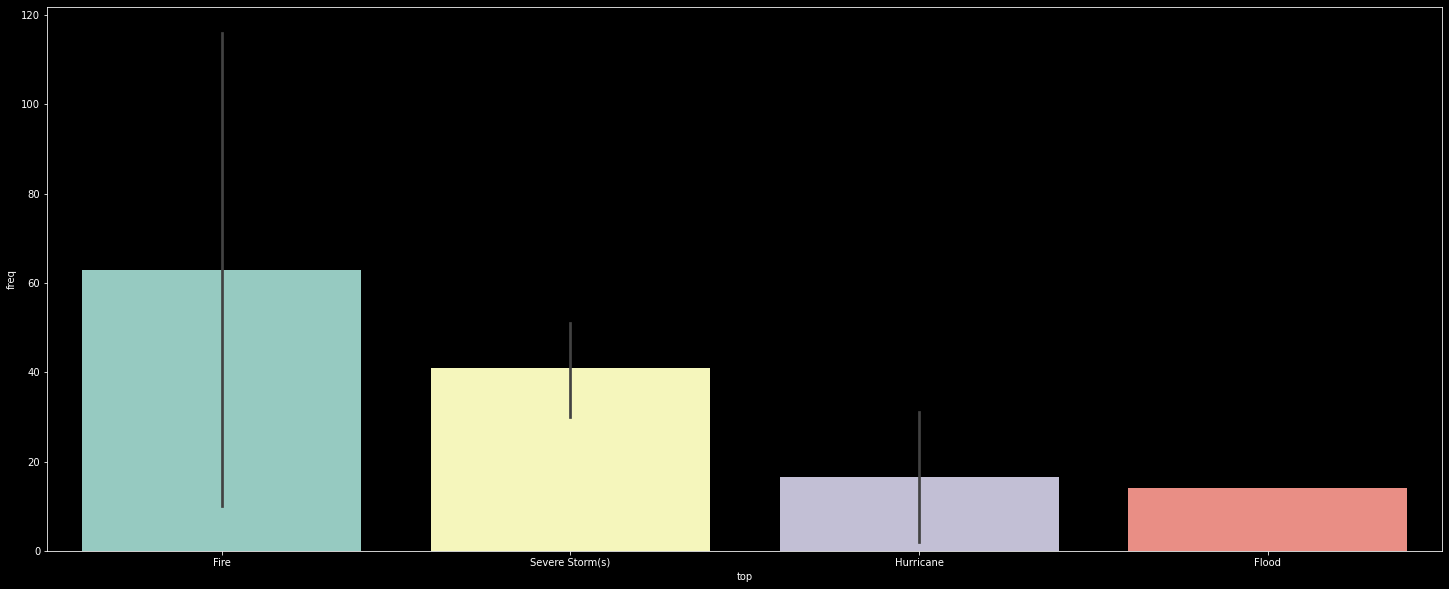

In [155]:
#  To Show which disater is prominent in US State
m=df[['incidentBeginDate','incidentType']].groupby('incidentBeginDate').describe()['incidentType'].reset_index()
plt.pyplot.figure(figsize=(25,10))
sns.barplot(x='top',y='freq',data =m);

### Texas is the most Disaster Prone state in US so exploring more about Texas

In [156]:
# Number of disasters happening in TEXAS since 2007
m=df.query('stateName=="Texas"')['declarationDate'].value_counts().reset_index()
m.head(10)

,index,declarationDate
0,2011,57
1,2008,25
2,2009,16
3,2016,4
4,2013,3
5,2015,2
6,2010,2
7,2017,1
8,2012,1


In [157]:
df = df.query('stateName=="Texas"')

fig = px.line(df, x="declarationDate", y="incidentType", title='Number of Disasters happened in Texas over the period of time')
fig.show()

In [158]:
# To show which disaster is prominent in TEXAS
values =df.query('stateName=="Texas"')['incidentType'].value_counts()
m=df.query('stateName=="Texas"')['incidentType']
fig = go.Figure(data=[go.Pie(labels=m, values=values)])
fig.update_layout(title='Texas disaster observation')
fig.show()

In [159]:
# To show which years are worst years in TEXAS from disaster perspective
import plotly.express as px
df = df.query('stateName=="Texas"')
fig = px.histogram(df, x="declarationDate", y="disasterNumber", color="declarationDate", marginal="rug",
                   hover_data=df.columns)
fig.update_layout(title='Number of Disasters happened in Texas over the period of time')
fig.show()

### Insert processed dataset in Azure Cloud

In [58]:
#defining connection parameters
import pyodbc
server = 'tcp:msc-dat-analytics.database.windows.net'
database = 'mscDAT'
username = 'dap'
password = 'India-data-analytics'
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)

In [59]:
cursor = cnxn.cursor()

In [51]:
cursor.execute('''
IF OBJECT_ID('US_Disaster_Events', 'U') IS NOT NULL
DROP TABLE US_Disaster_Events;
''')

In [52]:
df.head(1)

,data,declarationDate,incidentBeginDate,entryDate,updateDate,lastRefresh,disasterNumber,disasterName,declarationType,stateCode,stateName,incidentType,hash,id
0,0,2018,2018,2018,2018,2021,3397,TROPICAL STORM GITA,Emergency,AS,American Samoa,Hurricane,0d548a11763653005b93ff0697cacdc6bc9c9cce,5aa2d570cb4f0f7020b1703a


In [53]:
#Creating risk country table
cursor.execute('''
CREATE TABLE US_Disaster_Events
(
disasterId varchar(30),
disasterNumber INT,
stateCode char(5),
declarationType varchar(30),
stateName varchar(30),
incidentType varchar(30),
disasterDate INT,


PRIMARY KEY (disasterId)
--FOREIGN KEY (declarationDate) REFERENCES US_Disaster_Events(declarationDate)
);
''')

In [54]:
for index, row in df.iterrows():
    cursor.execute("INSERT INTO US_Disaster_Events(disasterId,disasterNumber,stateCode,declarationType,stateName,incidentType,disasterDate) values(?,?,?,?,?,?,?)", row.id, row.disasterNumber,row.stateCode,row.declarationType,row.stateName,row.incidentType,row.declarationDate)
cnxn.commit()


In [55]:
disasters_sql= SELECT * FROM US_Disaster_Events
df_disaster = pd.read_sql(disasters_sql,cnxn)
df_disaster(10)

SyntaxError: invalid syntax (Temp/ipykernel_71888/2973442654.py, line 1)

In [57]:
disasters_sql= "SELECT * FROM US_Disaster_Events"
disasters_sql

'SELECT * FROM US_Disaster_Events'

In [65]:
def select_disaterInfo(cnxn):      
    cur = cnxn.cursor()
    cur.execute("SELECT * FROM US_Disaster_Events")

    rows = cur.fetchall()
    
    for row in rows:
        print(row)
select_disaterInfo(cnxn)   

('5aa2d570cb4f0f7020b1703a', 3397, 'AS   ', 'Emergency', 'American Samoa', 'Hurricane', 2018)
('5aa2d570cb4f0f7020b1703b', 4352, 'NM   ', 'Major Disaster', 'New Mexico', 'Flood', 2017)
('5aa2d570cb4f0f7020b1703c', 4348, 'NY   ', 'Major Disaster', 'New York', 'Flood', 2017)
('5aa2d570cb4f0f7020b1703d', 3395, 'FL   ', 'Emergency', 'Florida', 'Hurricane', 2017)
('5aa2d570cb4f0f7020b1703e', 3392, 'LA   ', 'Emergency', 'Louisiana', 'Hurricane', 2017)
('5aa2d570cb4f0f7020b1703f', 3390, 'VI   ', 'Emergency', 'Virgin Islands of the U.S.', 'Hurricane', 2017)
('5aa2d570cb4f0f7020b17040', 3388, 'FL   ', 'Emergency', 'Florida', 'Hurricane', 2017)
('5aa2d570cb4f0f7020b17041', 3384, 'PR   ', 'Emergency', 'Puerto Rico', 'Hurricane', 2017)
('5aa2d570cb4f0f7020b17042', 4332, 'TX   ', 'Major Disaster', 'Texas', 'Hurricane', 2017)
('5aa2d570cb4f0f7020b17043', 4327, 'WY   ', 'Major Disaster', 'Wyoming', 'Flood', 2017)
('5aa2d570cb4f0f7020b17044', 4322, 'NY   ', 'Major Disaster', 'New York', 'Snow', 2017)


In [ ]:
cursor.close()
